In [1]:
# *Prepare Data*

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array

In [3]:
root = "/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Train/"
X_train = []
for folder in os.listdir(root):
    subdir = root +folder 
    for img_file in os.listdir(subdir):
        img = cv2.imread(subdir+ "/" +img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(160,160))
        img = img.astype('float32') / 255.0
        X_train.append(img_to_array(img))
        if(len(X_train) > 5000):
            break

X_train_grey = []
for folder in os.listdir(root):
    subdir = root +folder 
    for img_file in os.listdir(subdir):
        img = cv2.imread(subdir+ "/" +img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,(160,160))
        img = img.astype('float32') / 255.0
        X_train_grey.append(img_to_array(img))
        if(len(X_train_grey) > 5000):
            break            

In [4]:
X_train = np.array(X_train)
X_train_grey = np.array(X_train_grey)

print("X_train", X_train.shape)
print("X_train", X_train_grey.shape)

X_train (5007, 160, 160, 3)
X_train (5007, 160, 160, 1)


In [5]:
X_train, X_test, X_train_grey, X_test_grey = train_test_split(X_train,X_train_grey, test_size=0.2, random_state=1)

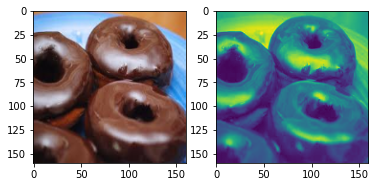

In [6]:
figure, axis = plt.subplots(1, 2)
axis[0].imshow(X_train[0])
axis[1].imshow(X_train_grey[0])
plt.rcParams["figure.figsize"] = (8,8)

# AutoEncoder

In [7]:
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [8]:
#def autoencoder():
inputs = keras.layers.Input(shape= [160,160,1])
d1 = down(128,(3,3),False)(inputs)
d2 = down(128,(3,3),False)(d1)
d3 = down(256,(3,3),True)(d2)
d4 = down(512,(3,3),True)(d3)
d5 = down(512,(3,3),True)(d4)

u1 = up(512,(3,3),False)(d5)
u1 = keras.layers.concatenate([u1,d4])
u2 = up(256,(3,3),False)(u1)
u2 = keras.layers.concatenate([u2,d3])
u3 = up(128,(3,3),False)(u2)
u3 = keras.layers.concatenate([u3,d2])
u4 = up(128,(3,3),False)(u3)
u4 = keras.layers.concatenate([u4,d1])
u5 = up(3,(3,3),False)(u4)
u5 = keras.layers.concatenate([u5,inputs])
output = keras.layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)

autoencoder = keras.models.Model(inputs=inputs, outputs=output)

2022-12-22 17:32:20.374302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 17:32:20.375363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 17:32:20.514395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 17:32:20.515299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 17:32:20.516065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [9]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 80, 80, 128)  1280        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 40, 40, 128)  147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 20, 20, 256)  296192      sequential_1[0][0]               
______________________________________________________________________________________________

In [10]:
historty = autoencoder.fit(X_train_grey, X_train, epochs = 50,batch_size = 32,verbose = 1)

2022-12-22 17:32:24.459615: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1230336000 exceeds 10% of free system memory.
2022-12-22 17:32:26.347189: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1230336000 exceeds 10% of free system memory.
2022-12-22 17:32:27.341680: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-22 17:32:29.557254: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


126/126 [==============================] - 29s 148ms/step - loss: 0.0529
Epoch 2/50
126/126 [==============================] - 18s 146ms/step - loss: 0.0150
Epoch 3/50
126/126 [==============================] - 19s 148ms/step - loss: 0.0128
Epoch 4/50
126/126 [==============================] - 19s 150ms/step - loss: 0.0121
Epoch 5/50
126/126 [==============================] - 19s 153ms/step - loss: 0.0112
Epoch 6/50
126/126 [==============================] - 20s 156ms/step - loss: 0.0109
Epoch 7/50
126/126 [==============================] - 20s 158ms/step - loss: 0.0105
Epoch 8/50
126/126 [==============================] - 20s 159ms/step - loss: 0.0105
Epoch 9/50
126/126 [==============================] - 20s 159ms/step - loss: 0.0103
Epoch 10/50
126/126 [==============================] - 20s 158ms/step - loss: 0.0101
Epoch 11/50
126/126 [==============================] - 20s 158ms/step - loss: 0.0100
Epoch 12/50
126/126 [==============================] - 20s 159ms/step - loss: 0.0098


In [11]:
predicted_images = autoencoder.predict(X_test_grey)

# *Test Set Images*

In [12]:
def plot_imgs(original_imgs, x_test_images, ae_imgs, size=10):
    figure, axis = plt.subplots(3, 5)
    axis[0, 0].imshow(original_imgs[0])
    axis[0, 1].imshow(original_imgs[1])
    axis[0, 2].imshow(original_imgs[2])
    axis[0, 3].imshow(original_imgs[3])
    axis[0, 4].imshow(original_imgs[4])
    axis[1, 0].imshow(x_test_images[0])
    axis[1, 1].imshow(x_test_images[1])
    axis[1, 2].imshow(x_test_images[2])
    axis[1, 3].imshow(x_test_images[3])
    axis[1, 4].imshow(x_test_images[4])
    axis[2, 0].imshow(ae_imgs[0])
    axis[2, 1].imshow(ae_imgs[1])
    axis[2, 2].imshow(ae_imgs[2])
    axis[2, 3].imshow(ae_imgs[3])
    axis[2, 4].imshow(ae_imgs[4])
    plt.rcParams["figure.figsize"] = (size,size)

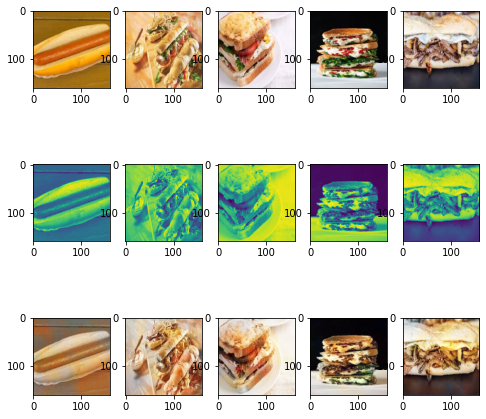

In [13]:
plot_imgs(X_test[:5], X_test_grey[:5],predicted_images[:5])